In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [2]:
dataset_path = os.listdir('bengali_digits')

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('bengali_digits' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])
    
    
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Types of classes labels found:  10
  Labels                                  image
0      0      dataset_path/0/1_14_BOG_1_317.jpg
1      0    dataset_path/0/1_22_Farid_3_318.jpg
2      0  dataset_path/0/1_B.BARIA_11_1_319.jpg
3      0  dataset_path/0/1_B.BARIA_11_1_320.jpg
4      0  dataset_path/0/1_B.BARIA_11_1_321.jpg
      Labels                                image
15495      9    dataset_path/9/1_TAN_1_1_1577.jpg
15496      9     dataset_path/9/1_THAK_13_316.jpg
15497      9  dataset_path/9/1_Tha_21_3_00032.jpg
15498      9  dataset_path/9/1_Tha_22_3_00033.jpg
15499      9  dataset_path/9/1_Tha_22_3_00035.jpg


In [3]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)


Total number of images in the dataset:  15500
0    1550
1    1550
2    1550
3    1550
4    1550
5    1550
6    1550
7    1550
8    1550
9    1550
Name: Labels, dtype: int64


In [4]:
import cv2
path = 'bengali_digits/'
dataset_path = os.listdir('bengali_digits')

IMG_DIMS = (165,165)
INPUT_SHAPE = (165,165, 3)

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, IMG_DIMS)
        images.append(img)
        labels.append(i)

In [5]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32')/255.0
images.shape

(15500, 165, 165, 3)

In [6]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['0' '0' '0' ... '9' '9' '9']
[0 0 0 ... 9 9 9]


In [7]:
y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(sparse=False), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [8]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_data, test_data, train_labels, test_labels = train_test_split(images, Y, test_size=0.3, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

print(train_data.shape, val_data.shape, test_data.shape)

(9765, 165, 165, 3) (1085, 165, 165, 3) (4650, 165, 165, 3)


In [9]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.12.0'

In [10]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(10, activation='softmax')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 165, 165, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 165, 165, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 165, 165, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 82, 82, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 82, 82, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 82, 82, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 41, 41, 128)       0     

In [11]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 11


In [12]:
#lrr= tf.keras.callbacks.ReduceLROnPlateau(
#                       monitor='val_accuracy', #Metric to be measured
#                       factor=.01, #Factor by which learning rate will be reduced
#                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
#                      min_lr=1e-7) #The minimum learning rate


EPOCHS = 25
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/25
306/306 [==============================] - 897s 3s/step - loss: 0.5966 - accuracy: 0.8110 - val_loss: 0.1288 - val_accuracy: 0.9604
Epoch 2/25
306/306 [==============================] - 899s 3s/step - loss: 0.1389 - accuracy: 0.9559 - val_loss: 0.0630 - val_accuracy: 0.9797
Epoch 3/25
306/306 [==============================] - 885s 3s/step - loss: 0.0756 - accuracy: 0.9776 - val_loss: 0.0498 - val_accuracy: 0.9843
Epoch 4/25
306/306 [==============================] - 881s 3s/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0.0336 - val_accuracy: 0.9917
Epoch 5/25
306/306 [==============================] - 872s 3s/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.0328 - val_accuracy: 0.9908
Epoch 6/25
306/306 [==============================] - 641s 2s/step - loss: 0.0267 - accuracy: 0.9920 - val_loss: 0.0268 - val_accuracy: 0.9945
Epoch 7/25
306/306 [==============================] - 579s 2s/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0243 - val_accuracy: 0.9917

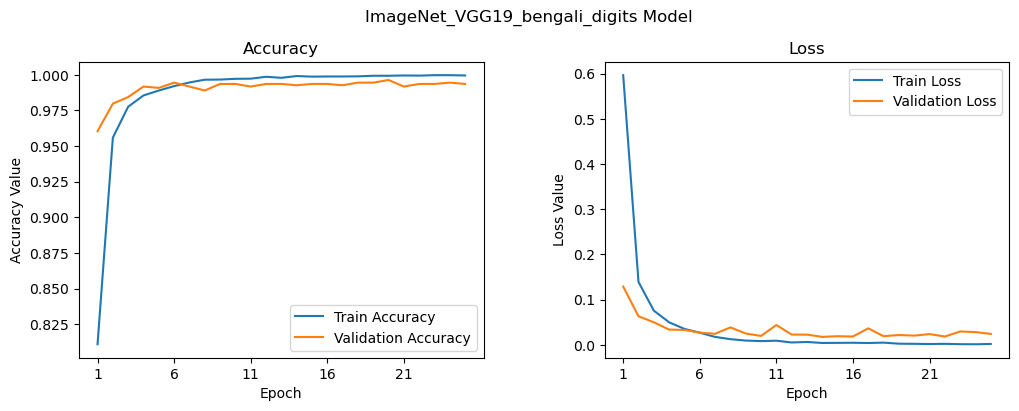

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ImageNet_VGG19_bengali_digits Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

plt.savefig('Train_Graph_ImageNet_VGG19_bengali_digits.png')

In [14]:
model.save('ImageNet_VGG19_bengali_digits.h5')

In [15]:
#scale test data
test_data.shape, test_labels.shape

((4650, 165, 165, 3), (4650, 10))

In [16]:
# Load Saved Deep Learning Models
model = tf.keras.models.load_model('ImageNet_VGG19_bengali_digits.h5')

y_pre_test=model.predict(test_data)
y_pre_test=np.argmax(y_pre_test,axis=1)
categories = ['0','1','2','3','4','5','6','7','8','9']

146/146 [==============================] - 188s 1s/step


In [17]:
# Model evaluated on training data
score = model.evaluate(train_data, train_labels, verbose=0)
print('Training score:', score[0])
print('Training accuracy:', score[1] * 100)

Training score: 1.1222200555494055e-05
Training accuracy: 100.0


In [18]:
# Model evaluated on validation data
score = model.evaluate(val_data, val_labels, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1] * 100)

Validation score: 0.024046994745731354
Validation accuracy: 99.35483932495117


In [19]:
# Model evaluated on test data
score = model.evaluate(test_data, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]  * 100)

Test score: 0.035333916544914246
Test accuracy: 99.37634468078613


In [20]:
import numpy as np
rounded_labels=np.argmax(test_labels, axis=1)
rounded_labels[0]

9

In [21]:
clf_report = pd.DataFrame(classification_report(rounded_labels, y_pre_test, target_names=categories, output_dict=True))
cm = confusion_matrix(rounded_labels, y_pre_test)
print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(rounded_labels, y_pre_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

Test Result:
Accuracy Score: 99.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.995680    0.991453    0.989451    0.993814    1.000000   
recall       0.997835    0.991453    0.989451    0.997930    0.995444   
f1-score     0.996757    0.991453    0.989451    0.995868    0.997717   
support    462.000000  468.000000  474.000000  483.000000  439.000000   

                   5           6           7           8           9  \
precision    0.99375    0.997854    0.995652    0.995680    0.984581   
recall       0.99375    0.993590    0.993492    0.997835    0.986755   
f1-score     0.99375    0.995717    0.994571    0.996757    0.985667   
support    480.00000  468.000000  461.000000  462.000000  453.000000   

           accuracy    macro avg  weighted avg  
precision  0.993763     0.993792      0.993769  
recall     0.993763     0.993754      0.993763  
f1-score   0.993763

In [22]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    y_score=model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

146/146 [==============================] - 188s 1s/step


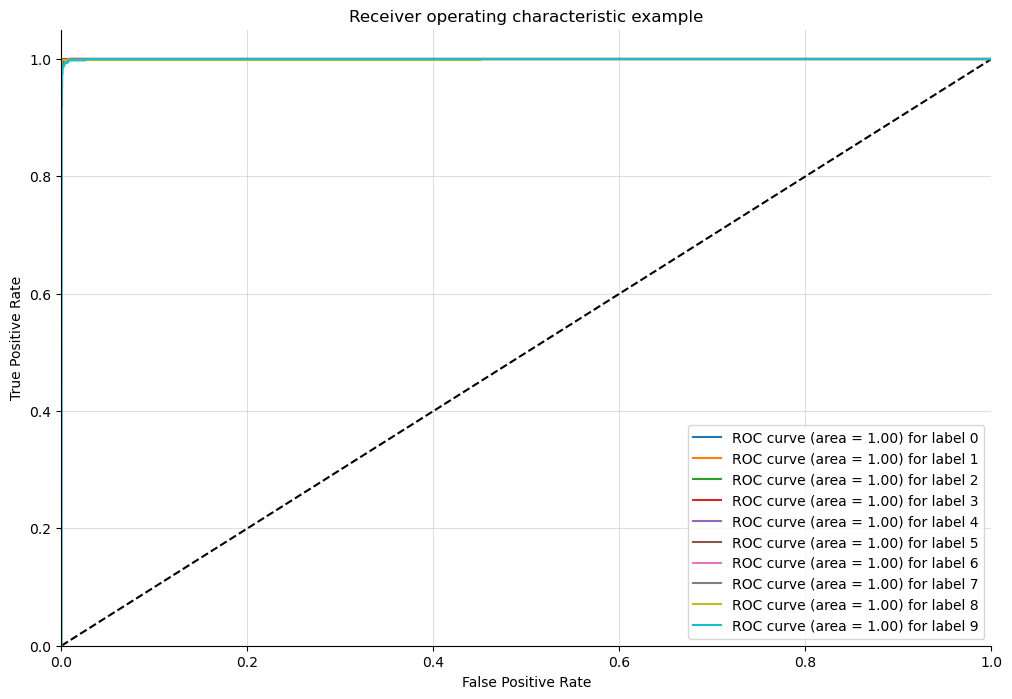

In [23]:
plot_multiclass_roc(model, test_data, rounded_labels, n_classes=10, figsize=(12, 8))

In [24]:
# ROC AUC scores
y_pred=model.predict(test_data)
macro_roc_auc_ovo = roc_auc_score(test_labels, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_labels, y_pred, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(test_labels, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_labels, y_pred, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

146/146 [==============================] - 188s 1s/step
One-vs-One ROC AUC scores:
0.999851 (macro),
0.999852 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999851 (macro),
0.999852 (weighted by prevalence)


In [25]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

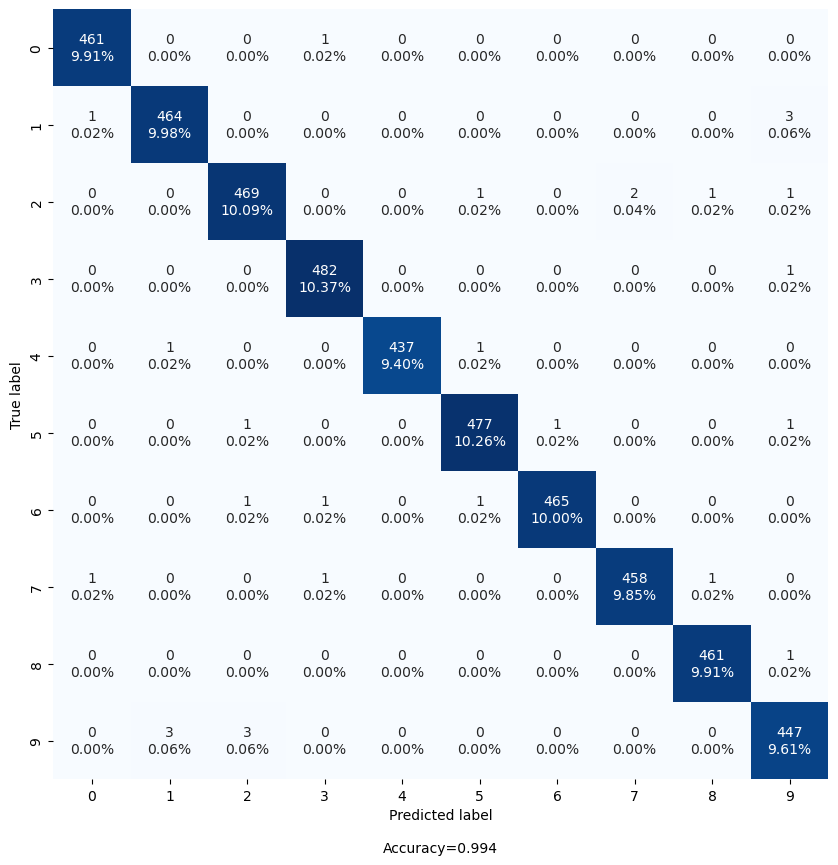

In [26]:
# Monkey Pox = 0 ,  Otyhers =1
categories = ['0','1','2','3','4','5','6','7','8','9']
make_confusion_matrix(cm, categories=categories,figsize=(10,10), cbar=False)
plt.savefig("ConfusionMatrix3.png")